In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import starfish
import starfish.data
from starfish import FieldOfView
from starfish.types import Indices

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment = starfish.data.osmFISH(use_test_data=True)
stack = experiment["fov_000"][FieldOfView.PRIMARY_IMAGES]

100%|██████████| 45/45 [00:01<00:00, 22.97it/s]


## Load pysmFISH results

The Field of view that we've used for the test data corresponds to Aldoc, imaged in round one, in position 33. We've also packaged the results from the osmFISH publication for this target to demonstrate that starfish is capable of recovering the same results. 

The below commands parse and load the results from this file. 

In [4]:
def load_results(pickle_file):
    with open(pickle_file, "rb") as f:
        return pickle.load(f)

def get_benchmark_peaks(loaded_results, redo_flag=False):

    if not redo_flag:
        sp = pd.DataFrame(
            {
                "y":loaded_results["selected_peaks"][:,0],
                "x":loaded_results["selected_peaks"][:,1],
                "selected_peaks_int": loaded_results["selected_peaks_int"],
            }
        )
    else:
        p = peaks(loaded_results)
        coords = p[p.thr_array==loaded_results["selected_thr"]].peaks_coords
        coords = coords.values[0]
        sp = pd.DataFrame({"x":coords[:,0], "y":coords[:,1]})

    return sp

benchmark_results = load_results("./data/EXP-17-BP3597_hyb1_Aldoc_pos_33.pkl")
benchmark_peaks = get_benchmark_peaks(benchmark_results, redo_flag=False)

# Re-produce pysmFISH Results

## Filtering code

Remove background using a gaussian high-pass filter, then enhance spots with a Laplacian filter.

In [5]:
filter_ghp = starfish.image.Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
filter_laplace = starfish.image.Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)

stack_ghp = filter_ghp.run(stack, in_place=False)
stack_ghp_laplace = filter_laplace.run(stack_ghp, in_place=False)

1it [00:00,  8.41it/s]
1it [00:00,  8.68it/s]


Max project over Z, then select the 1st `(0)` channel for visualization in the notebook to demonstrate the effect of background removal using these filters. 

In [6]:
mp = stack_ghp_laplace.max_proj(Indices.Z)
array_for_visualization = mp.xarray.sel({Indices.CH: 0}).squeeze()

100%|██████████| 1/1 [00:00<00:00, 117.81it/s]


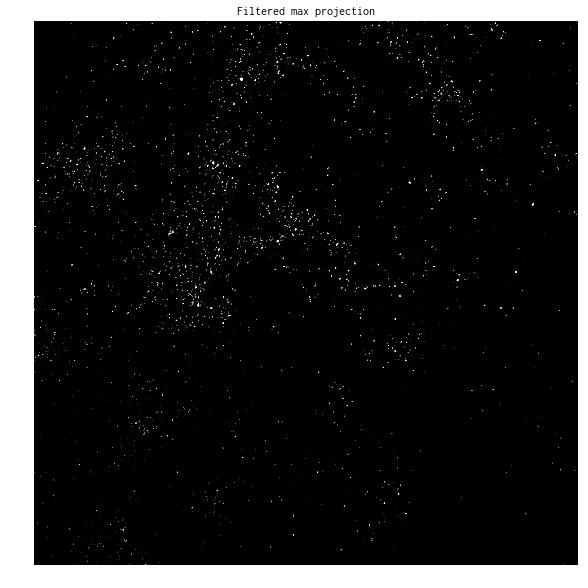

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(
    array_for_visualization, 
    cmap="gray", 
    vmin=np.percentile(array_for_visualization, 98), 
    vmax=np.percentile(array_for_visualization, 99.9),
)
plt.title("Filtered max projection")
plt.axis("off");

### Spot Finding

osmFISH uses a peak finder that distinguishes local maxima from their surroundings whose absolute intensities exceed a threshold value. It tests a number of different thresholds, building a curve from the number of peaks detected at each threshold. A threshold in the _stable region_ of the curve is selected, and final peaks are called with that threshold. 

This process is repeated independently for each round and channel. Here we show this process on a single round and channel to demonstrate the procedure. 

In [10]:
lmp = starfish.spots.SpotFinder.LocalMaxPeakFinder(
    min_distance=6,
    stringency=0,
    min_obj_area=6, 
    max_obj_area=600,
)
spot_intensities = lmp.run(mp)

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:27<00:20,  2.06it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...


### Spot finding QA

Select spots in the first round and channel and plot their intensities

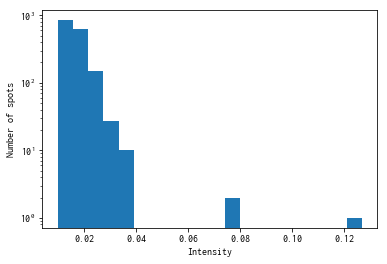

In [11]:
aldoc_spot_intensities = spot_intensities.sel({Indices.ROUND.value: 0, Indices.CH.value: 0})

plt.hist(aldoc_spot_intensities, bins=20)
plt.yscale("log")
plt.xlabel("Intensity")
plt.ylabel("Number of spots");

Starfish enables maximum projection and slicing of the ImageStack object. However, these projections will maintain the 5d shape, leaving one-length dimensions for any array that has been projected over. Here the maximum projection of the z-plane of the ImageStack is calculated. From it, the first channel and round are selected, and `squeeze` is used to eliminate any dimensions with only one value, yielding a two-dimension `(x, y)` tile that can be plotted. 

In [12]:
maximum_projection_5d = stack_ghp_laplace.max_proj(Indices.Z)
maximum_projection_2d = mp.sel({Indices.CH: 0, Indices.ROUND: 0}).xarray.squeeze()

100%|██████████| 1/1 [00:00<00:00, 106.78it/s]


Use the maximum projection to plot all spots detected by starfish:

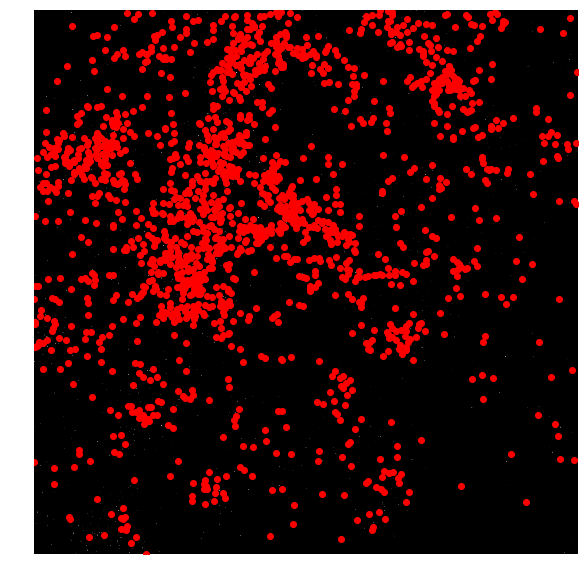

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(
    maximum_projection_2d, 
    cmap = "gray", 
    vmin=np.percentile(maximum_projection_2d, 98), 
    vmax=np.percentile(maximum_projection_2d, 99.9),
)
plt.plot(spot_intensities[Indices.X.value], spot_intensities[Indices.Y.value], "or")
plt.axis("off");

## Compare to pySMFISH peak calls

Plot spots detected in the benchmark as blue spots, and overlay spots from starfish as orange x's. Starfish detects the same spot positions, but 41 fewer spots in total. 

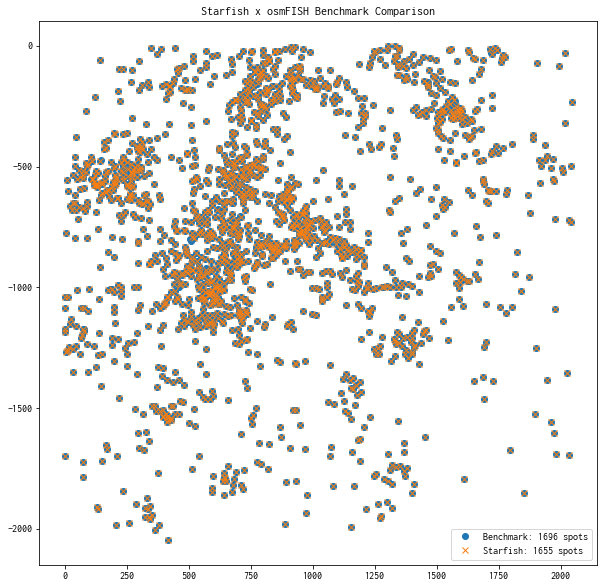

In [14]:
benchmark_spot_count = len(benchmark_peaks)
starfish_spot_count = len(spot_intensities)

plt.figure(figsize=(10,10))
plt.plot(benchmark_peaks.x, -benchmark_peaks.y, "o")
plt.plot(spot_intensities[Indices.X.value], -spot_intensities[Indices.Y.value], "x")

plt.legend(["Benchmark: {} spots".format(benchmark_spot_count),
            "Starfish: {} spots".format(starfish_spot_count)])
plt.title("Starfish x osmFISH Benchmark Comparison");

In [13]:
spot_difference = benchmark_spot_count - starfish_spot_count
print(f"Starfish finds {spot_difference} fewer spots")
assert spot_difference == 41  # for starfish testing purposes

Starfish finds 41 fewer spots
